# ELEC-E5431- Phung Duc Thao – 913223 - Assignment 2

#### Import Packages

In [1]:
import numpy as np
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
from scipy.io import loadmat
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from random import seed
from random import random
from random import randrange

### Stump classifier

In [2]:
def single_tree_test_err(node, X, y, Xt, yt):
    clf = tree.DecisionTreeClassifier(max_leaf_nodes=node)
    clf.fit(X, y)
    yhat = clf.predict(Xt)
    Err = np.sum(yhat * yt.reshape(-1) < 0) / len(yt)
    return Err

In [3]:
mat_train = loadmat('data_train.mat')
mat_test = loadmat('data_test.mat')

In [4]:
x_train = np.array(mat_train["X"])
y_train = mat_train["y"]

x_test = mat_test["Xt"]
y_test = mat_test["yt"]

In [5]:
# Error for single stump of test dataset
single_stump = single_tree_test_err(2,x_train,y_train,x_test,y_test)

In [6]:
# Error for 245-node tree of test dataset
node_245_tree = single_tree_test_err(245,x_train,y_train,x_test,y_test)

# Question 1

In this problem you will implement the bagging algorithm in the binary classification problem and use it to redo the Figure 3.4 and Figure 3.5.

(a) Implement the bagging algorithm for classification described in algorithm 3.1 by yourself by writing a function MyBagging having outputs an object Trees that contains the B bagged decision trees and a vector or list **err** that contains the B out-of-bag (OOB) training errors when a new tree is added;. The function would in Matlab have the format

**function [Trees,Err] = MyBagging(X,y,B)**

Before running, the MyBagging algorithm run **rng('default')** in Matlab or **np.random.seed(0)** in python for reproducibility. Otherwise, your plot will change slightly due to different random seeds used to generate the bootstrap samples.

(b) Write a function **PredictBagging** that computes the predicted class labels for input data **X** for each bagged tree as well as the error rate at each iteration, i.e, when a new tree is added, given the true labels y. The inputs for the function are **Trees** which is the output from **MyBagging** and then the data sets **X** and **y** for which you wish to compute the predicted labels ad the error rates.

In Matlab, the function would have the following format:

**function [yhat,Err] = PredictBagging(Trees,X,y)**

(c) Use the functions you made in problem 1(a) and 1(b) to redo the Figure 3.4. The data used in this example is given in data_train.mat and data_test.mat, where the latter file contains the data for testing and the former for training the classifier. Also compute and plot the confusion matrix for your predictions of test data as shown in Figure 3.5.

Note: You should use fitctree in Matlab (available in Statistics and machine learning toolbox) or **DecisionTreeClassifier** in python's scikit-learn to compute the classification decision tree (with their default options). A python script to load the data to your python environment is given in the file **load_data.py**

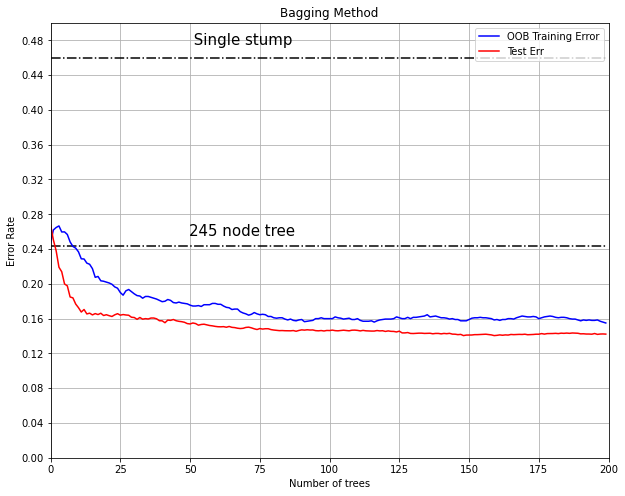

In [7]:
# Number of bagged decision trees
num_trees = 200

# Dictionary to sample OOB data each iteration
OOB_dict = {}

# Set seed for reproducibility
np.random.seed(0)

# Add the indexes which is not in the datasets when resampling
def addToOOB(index):
    if index not in OOB_dict:
        OOB_dict[index]=0
    return index

# Append prediction into the OOB dictionary
def addPredictionTree(tree_prediction,i,index):
    OOB_dict[index] += tree_prediction[i]

# Function to create a random number between [-1,1] if votes are tie
def makeVoteTieRandom(index,y_pred):
    if y_pred == 0: # If vote tie, make a random number
        OOB_dict[index]=np.random.choice([-1,1])

# Majority Vote Function
def assignVoteTie(sumAverage,y_set):
    y_pred = np.sign(sumAverage) # Sign the values of numpy array to -1,0,1
    y_pred[y_pred==0] = 1 # If the vote is tie, assign them to 1
    # Get the total error divided by the length of test set
    Err = np.sum(y_pred.reshape(len(y_pred),1) * (y_set) < 0) / len(y_set)
    return Err # Return Error

# Bagging Algorithm for Classification Problem
def MyBagging(X,y,B):
    trees,Err = [],[]
    for _ in range(B): # For each bag, perform
        # Get randomized index for resampling the training set
        idxs = np.random.choice(len(y),replace=True,size=len(y))
        # Get the indexes for out of bag in training set
        OOB_indexes = [addToOOB(i) for i in range(len(y)) if i not in idxs]
        # Append a new tree by fitting with resampled data
        trees.append(tree.DecisionTreeClassifier().fit(X[idxs], y[idxs]))
        # Get prediction for OOB data using indexes
        tree_prediction = trees[-1].predict(X[OOB_indexes])
        # Append prediction to the OOB data list
        [addPredictionTree(tree_prediction,i,index) for i,index in enumerate(OOB_indexes)]
        # If the sum of previous bag uptil now are 0, so make a random prediction [-1,1]
        [makeVoteTieRandom(index,y_pred) for index,y_pred in OOB_dict.items()]
        # Get value from OOB dataset and predict them and compared with list y_train
        y_pred_OOB = y[list(OOB_dict.keys())].reshape(-1) == np.sign(list(OOB_dict.values()))
        Err.append(len(y_pred_OOB[y_pred_OOB==False])/len(y_pred_OOB))
    return trees,Err # Return Tree and Error

# Run the MyBagging function to get trees and err values
trees,err = MyBagging(x_train,y_train,B=num_trees)

# Predict Bagging function for Test Set
def PredictBagging(Trees,X,y): # Get the Tree, X and Y Test set
    y_test = [eachTree.predict(X) for eachTree in Trees] # For each tree, predict the X test set
    yhat = np.cumsum(y_test,axis=0) # Sum up all the voting accumulated to perform majority voting
    y_pred = np.sign(yhat[-1]) # Assign -1,0,1 mapping
    y_pred[y_pred==0] = np.random.choice([-1,1]) # If the vote is tie, assign them to [-1,1] randomly
    Err = [assignVoteTie(eachBag,y) for eachBag in yhat] # Get the accumulated error when new tree is added
    return y_pred,Err # Return prediction from bagging and Error for accumulated trees

# Use the trees and test set to predict the bagging to get the yhat prediction and error from test set
yhat,ypred_test = PredictBagging(trees,x_test,y_test)

# Plotting the results
x = np.linspace(0, len(err)-1, len(err))
figure(figsize=(10,8))
ax = plt.axes()
ax.plot(x, err,'b', x,ypred_test,'r')

# Plotting single stump and 245-node-tree classifier lines
ax.hlines(single_stump,min(x),max(x),linestyles='dashdot',colors='black')
ax.text((min(x)+max(x))/2-50, 0.48, ' Single stump', ha='left', va='center',size=15)
ax.hlines(node_245_tree,min(x),max(x),linestyles='dashdot',colors='black')
ax.text((min(x)+max(x))/2-50, 0.26, '245 node tree', ha='left', va='center',size=15)

ax.yaxis.set_major_locator(plt.MaxNLocator(15))
ax.set(xlim=(0, len(err)), 
       ylim=(0, 0.5),
       xlabel='Number of trees', ylabel='Error Rate',
       title='Bagging Method')
ax.grid()
ax.legend(['OOB Training Error','Test Err'])

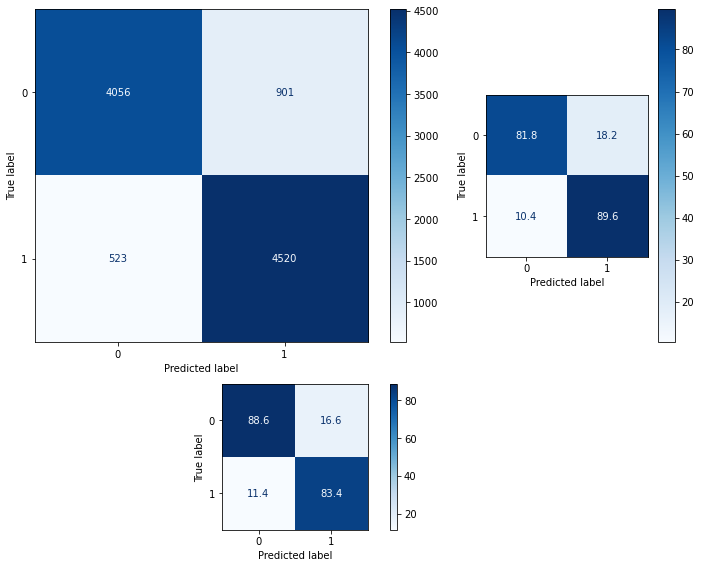

In [8]:
# Plotting the confusion matrix using the Err and Y prediction above
figure(figsize=(10,8))
left_up = plt.subplot2grid((3,3), (0,0), colspan=2,rowspan=2)
left_right = plt.subplot2grid((3,3), (0, 2), rowspan=2)
down = plt.subplot2grid((3,3), (2, 0),colspan=2)
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, yhat,labels=[-1,1]))
disp.plot(cmap=plt.cm.Blues,ax=left_up)
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, yhat,labels=[-1,1],normalize="true")*100)
disp.plot(cmap=plt.cm.Blues,ax=left_right, values_format='.1f')
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, yhat,labels=[-1,1],normalize="pred")*100)
disp.plot(cmap=plt.cm.Blues,ax=down, values_format='.1f')
plt.tight_layout()

# Question 2

In this problem you will implement the random forest algorithm in the binary classification problem and use it to redo the Figure 3.6.

(a) Implement the random forest algorithm for classification described in algorithm 3.2 by yourself by writing a function named MyRandomForest. The output of this function are an object **Trees** which contains the **B** decision trees classifiers and a vector or list **err** that contains the **B** out-of-bag (OOB) training error when a new tree is added. Besides the training data in **X** and **y**, the other inputs for the function are **B** (the number of learners), **d** (number of features in each split), and **min** (minimum node size). In Matlab, the function would have the following format:

**function [Trees,Err] = MyRandomForest(X,y,B,d,nmin)**

(b) Use the functions you have made to redo the Figure 3.6. Use the following parameter values: **d=2** and **nmin=3,B=200**. Also compute and plot the confusion matrix for your predictions of test data as shown in Figure 3.5

Hint: Again you should use **DecisionTreeClassifier** python (scikit-learn), respectively, to compute the classification decision tree. Note also that you can use the **PredictBagging** function to compute the predicted class labels for an input data **X**

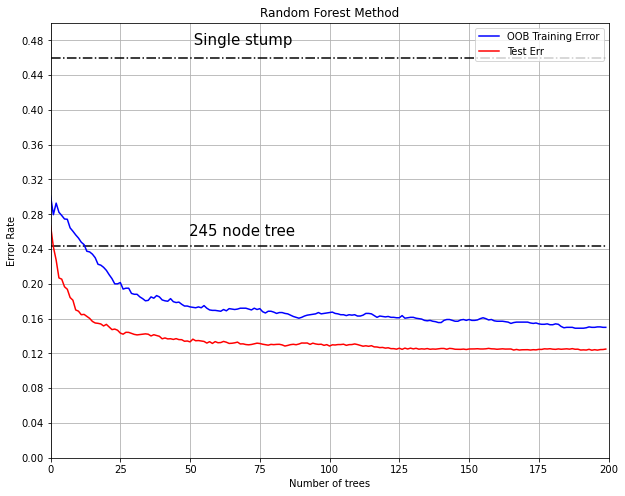

In [9]:
# Number of bagged decision trees
num_trees = 200

# Set seed for reproducibility
np.random.seed(0)

OOB_dict = {}

nmin = 3 # the minimum node size
d = 2 # number of features in each split

# Add the indexes which is not in the datasets when resampling
def addToOOB(index):
    if index not in OOB_dict:
        OOB_dict[index]=0
    return index

# Append prediction into the OOB dictionary
def addPredictionTree(tree_prediction,i,index):
    OOB_dict[index] += tree_prediction[i]

# Function to create a random number between [-1,1] if votes are tie
def makeVoteTieRandom(index,y_pred):
    if y_pred == 0: # If vote tie, make a random number
        OOB_dict[index]=np.random.choice([-1,1])
        
# Majority Vote Function
def assignVoteTie(sumAverage,y_set):
    y_pred = np.sign(sumAverage) # Sign the values of numpy array to -1,0,1
    y_pred[y_pred==0] = 1 # If the vote is tie, assign them to 1
    # Get the total error divided by the length of test set
    Err = np.sum(y_pred.reshape(len(y_pred),1) * (y_set) < 0) / len(y_set)
    return Err # Return Error

def MyRandomForest(X,y,B,d,nmin):
    trees,Err = [],[]
    for _ in range(B): # For each bag, perform
        # Get randomized index for resampling the training set
        idxs = np.random.choice(len(y),replace=True,size=len(y))
        # Get the indexes for out of bag in training set
        OOB_indexes = [addToOOB(i) for i in range(len(y)) if i not in idxs]
        # Append a new tree by fitting with resampled data
        trees.append(tree.DecisionTreeClassifier(max_features=d,min_samples_leaf=nmin).fit(X[idxs], y[idxs]))
        # Get prediction for OOB data using indexes
        tree_prediction = trees[-1].predict(X[OOB_indexes])
        # Append prediction to the OOB data list
        [addPredictionTree(tree_prediction,i,index) for i,index in enumerate(OOB_indexes)]
        # If the sum of previous bag uptil now are 0, so make a random prediction [-1,1]
        [makeVoteTieRandom(index,y_pred) for index,y_pred in OOB_dict.items()]
        y_pred_OOB = y[list(OOB_dict.keys())].reshape(-1) == np.sign(list(OOB_dict.values()))
        Err.append(len(y_pred_OOB[y_pred_OOB==False])/len(y_pred_OOB))
    return trees,Err # Return Tree and Error

# Predict Bagging function for Test Set
def PredictBagging(Trees,X,y): # Get the Tree, X and Y Test set
    # For each tree, predict the X test set
    y_test = [eachTree.predict(X) for eachTree in Trees] 
    # Sum up all the voting accumulated to perform majority voting
    yhat = np.cumsum(y_test,axis=0) 
    # Assign -1,0,1 mapping
    y_pred = np.sign(yhat[-1])
    y_pred[y_pred==0] = 1 # If the vote is tie, assign them to 1
    # Get the all error for accumulated trees
    Err = [assignVoteTie(eachBag,y) for eachBag in yhat] 
    return y_pred,Err # Return prediction from bagging and Error for accumulated trees

# Running the MyRandomForest with X,y training sets, B (num_of_trees), d and node min
trees,err = MyRandomForest(X=x_train,y=y_train,B=num_trees,d=d,nmin=nmin)

# Get the tree from above function and inputting the PredictBagging for predicting test set
yhat,ypred_test = PredictBagging(trees,x_test,y_test)

# Get both the Errors from OOB and Test set for plotting
x = np.linspace(0, len(err)-1, len(err))
figure(figsize=(10,8))
ax = plt.axes()
ax.plot(x, err,'b', x,ypred_test,'r')

# Plotting single stump and 245-node-tree classifier lines
ax.hlines(single_stump,min(x),max(x),linestyles='dashdot',colors='black')
ax.text((min(x)+max(x))/2-50, 0.48, ' Single stump', ha='left', va='center',size=15)
ax.hlines(node_245_tree,min(x),max(x),linestyles='dashdot',colors='black')
ax.text((min(x)+max(x))/2-50, 0.26, '245 node tree', ha='left', va='center',size=15)
ax.yaxis.set_major_locator(plt.MaxNLocator(15))
ax.set(xlim=(0, len(err)), 
       ylim=(0, 0.5),
       xlabel='Number of trees', ylabel='Error Rate',
       title='Random Forest Method')
ax.grid()
ax.legend(['OOB Training Error','Test Err'])

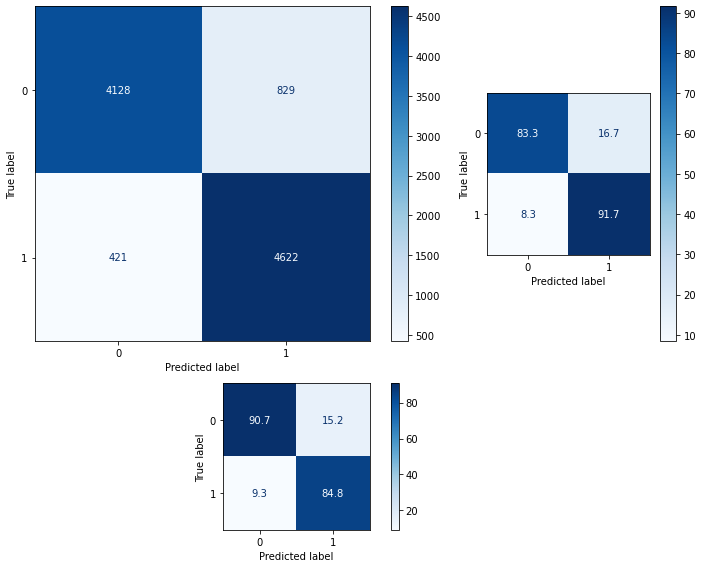

In [10]:
# Plotting the confusion matrix using the Err and Y prediction above
figure(figsize=(10,8))
left_up = plt.subplot2grid((3,3), (0,0), colspan=2,rowspan=2)
left_right = plt.subplot2grid((3,3), (0, 2), rowspan=2)
down = plt.subplot2grid((3,3), (2, 0),colspan=2)
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, yhat,labels=[-1,1]))
disp.plot(cmap=plt.cm.Blues,ax=left_up)
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, yhat,labels=[-1,1],normalize="true")*100)
disp.plot(cmap=plt.cm.Blues,ax=left_right, values_format='.1f')
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, yhat,labels=[-1,1],normalize="pred")*100)
disp.plot(cmap=plt.cm.Blues,ax=down, values_format='.1f')
plt.tight_layout()

# Question 3

In this problem you will implement the Adaboost.M1 algorithm and use it to redo the Figure 4.1. Use Matlab or Python.

(a) Implement the Adaboost.M1 algorithm described in algorithm 4.1 using stumps (classification decision trees with two terminal nodes) as the base learner. Write a function **MyAdaBoostM1**, whose outputs are an object (so a list or cell) **G** that contains the **M** stumps (i.e, 2-node decision trees) and list/vector **alpha** that contains weights of each boosting iteration.

In Matlab, the function has the following format:

**function [G,alpha] = MyAdaBoostM1(X,y,M)**

(b) Write a function **PredictAdaBoostM1** that computes the predicted data labels and error rate at each boosting iteration for a given input data. The inputs of the function are **G** and **alpha** which are the outputs from **MyAdaBoostM1** as well as **X** and **y** which are the input data of features and class labels, respectively, for which you wish to compute the predicted labels (**yhat**) and the error rate (**Err**). In Matlab, the function has the following format:

**function [yhat,Err] = PredictAdaBoostM1(G,alpha,X,y)**

(c) Use the functions you made in a) and b) to redo the Figure 4.1a. Also compute and plot the confusion matrix for you predictions of test data as shown in Figure 4.2. Training and test data are given in **data_train.mat** and **data_test.mat**. A python script to laod the data to your python environment is given in the file **load_data.py**

Hint: Again you should use **fitctree** or **DecisionTreeClassifier** in Matlab or python, respectively, to compute the stumps.

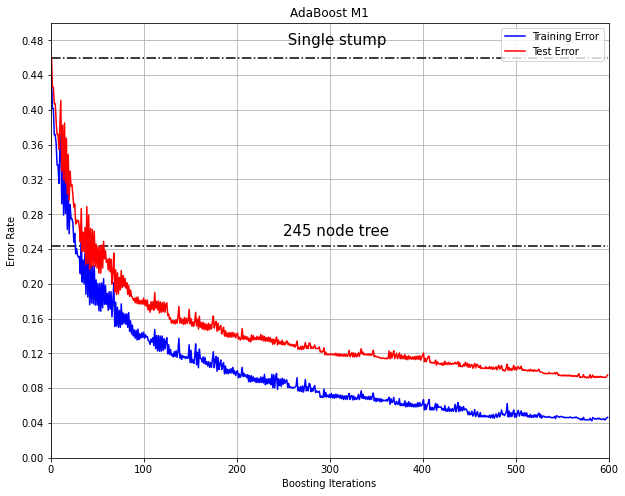

In [11]:
M = 600 # Number of decision trees or boosting iterations
# Set seed for reproducibility
np.random.seed(0)
# Training Error for storing the Error rate when assigning weights
train_Err = []

def calculateWeight(alpha,decisionStump,X):
    return alpha*decisionStump.predict(X)

def calculateErr(y_pred,y):
    y_pred[y_pred==0] = 1
    return np.sum(y_pred.reshape(len(y_pred),1) * (y) < 0) / len(y)
    
def MyAdaBoostM1(X,y,M):
    global train_Err
    N = len(y)
    G, estimator_weight_list = [], []
    #Initialize the sample weights
    sample_weight = np.ones(N) / N
    for m in range(M):
        g = tree.DecisionTreeClassifier(max_leaf_nodes=2).fit(X, y, sample_weight=sample_weight.reshape(-1)) # Create decision stump
        G.append(g) # Append decision stump
        y_predict = g.predict(X).reshape(len(y),1) # fit a stump classifier
        err = (y_predict != y) # misclassifications between actual and prediction
        # Reference in numpy.average take the sum of weights with matrix divided with sum of weights
        # https://numpy.org/doc/stable/reference/generated/numpy.average.html
        estimator_error = np.average(err, weights=sample_weight, axis=0) # weighted error
        estimator_weight = np.log((1. - estimator_error) / estimator_error) # estimator weight
        estimator_weight_list.append(estimator_weight.copy()) # Append estimator weight for each stump
        #compute the sample weights or update weights
        sample_weight *= np.exp(estimator_weight*err).reshape(-1)
    Ypred = [calculateWeight(estimator_weight_list[i],G[i],X) for i in range(len(estimator_weight_list))]
    Ypred = np.cumsum(Ypred,axis=0)
    Ypred_list = [np.sign(ypred) for ypred in Ypred]
    train_Err = [calculateErr(ypred,y) for ypred in Ypred_list]
    return G,estimator_weight_list

def PredictAdaBoostM1(G,alpha,X,y):
    Err = []
    Ypred = [calculateWeight(alpha[i],G[i],X) for i in range(len(alpha))]
    Ypred = np.cumsum(Ypred,axis=0)
    Ypred_list = [np.sign(ypred) for ypred in Ypred]
    Err = [calculateErr(ypred,y) for ypred in Ypred_list]
    return Ypred_list[-1],Err

G,alpha = MyAdaBoostM1(x_train,y_train,M)
yhat,Err = PredictAdaBoostM1(G,alpha,x_test,y_test)

x = np.linspace(0, len(G)-1, len(G))
figure(figsize=(10,8))
ax = plt.axes()

ax.hlines(single_stump,min(x),max(x),linestyles='dashdot',colors='black')
ax.text((min(x)+max(x))/2-50, 0.48, ' Single stump', ha='left', va='center',size=15)
ax.hlines(node_245_tree,min(x),max(x),linestyles='dashdot',colors='black')
ax.text((min(x)+max(x))/2-50, 0.26, '245 node tree', ha='left', va='center',size=15)
ax.yaxis.set_major_locator(plt.MaxNLocator(15))

ax.plot(x, train_Err,'b',x,Err,'r')
ax.yaxis.set_major_locator(plt.MaxNLocator(15))
ax.set(xlim=(0, len(G)), 
       ylim=(0, 0.5),
       xlabel='Boosting Iterations', ylabel='Error Rate',
       title='AdaBoost M1')
ax.grid()
ax.legend(['Training Error','Test Error'])
train_Err_2 = train_Err.copy()

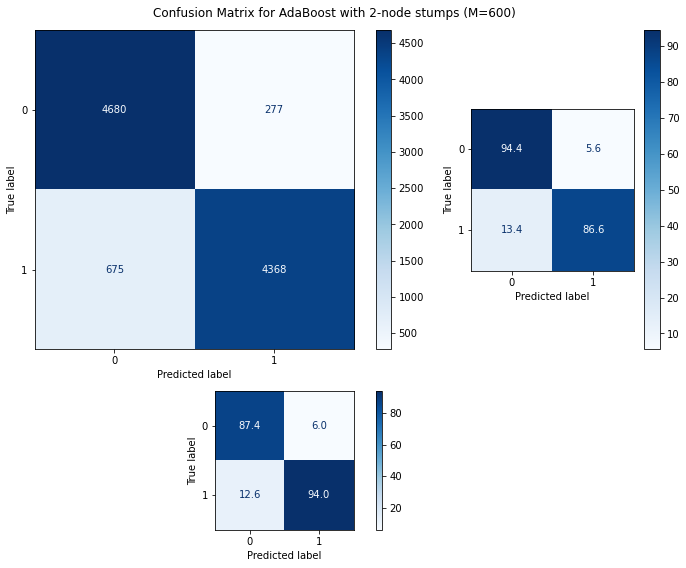

In [12]:
# Plotting the confusion matrix using the Err and Y prediction above
figure(figsize=(10,8))
left_up = plt.subplot2grid((3,3), (0,0), colspan=2,rowspan=2)
left_right = plt.subplot2grid((3,3), (0, 2), rowspan=2)
down = plt.subplot2grid((3,3), (2, 0),colspan=2)
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, yhat,labels=[-1,1]))
disp.plot(cmap=plt.cm.Blues,ax=left_up)
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, yhat,labels=[-1,1],normalize="true")*100)
disp.plot(cmap=plt.cm.Blues,ax=left_right, values_format='.1f')
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, yhat,labels=[-1,1],normalize="pred")*100)
disp.plot(cmap=plt.cm.Blues,ax=down, values_format='.1f')
plt.suptitle("Confusion Matrix for AdaBoost with 2-node stumps (M=600)")
plt.tight_layout()